# Tuning the two layer model

- take pre-calculated abrupt4xCO2 and piControl values of radiation and near-surface air temperature
- tune the model of Geoffroy et al. (2013): https://journals.ametsoc.org/view/journals/clim/26/6/jcli-d-12-00196.1.xml

In [1]:
from openscm_twolayermodel import TwoLayerModel
from openscm_twolayermodel.constants import DENSITY_WATER, HEAT_CAPACITY_WATER

from tqdm.notebook import tqdm
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
import glob
import matplotlib.pyplot as pl
import warnings
import json
from scipy.interpolate import interp1d
from openscm_units import unit_registry as ur
from scmdata import ScmRun
warnings.simplefilter('ignore')

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [3]:
models = ['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KIOST-ESM',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NESM3',
 'NorCPM1',
 'NorESM1-F',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

In [4]:
piControl = {}
abrupt4xCO2 = {}
F4x_gregory = {}
eff = {}
lambda0 = {}
C = {}
C0 = {}
gamma = {}
nyears = {}
N = {}
T = {}
T4x_gregory = {}
hflux = {}
lam_eff = {}
ohc = {}
qtot = {}
tg = {}
tlev = {}
time = {}
tu = {}
tl = {}
du = {}
dl = {}

accepted_models = []

# Models only provided r1 in any seriousness. GISS and CanESM have a couple of variants, we'll stick to r1 for consistency.
for model in tqdm(models):
    piControl[model] = {}
    abrupt4xCO2[model] = {}
    if model=='EC-Earth3':
        dir4co2 = glob.glob('../data_input/cmip6/%s/abrupt-4xCO2/r8i*/' % model)
    else:
        dir4co2 = glob.glob('../data_input/cmip6/%s/abrupt-4xCO2/r1i*/' % model)
    dirpiC  = glob.glob('../data_input/cmip6/%s/piControl/r1i*/' % model)
    if model=='CanESM5' or model=='GISS-E2-1-G':
        dir4co2 = [x for x in dir4co2 if 'r1i1p1f1' in x]
        dirpiC  = [x for x in dirpiC if 'r1i1p1f1' in x]
    # experiment missing? skip model
    if len(dir4co2)==0 or len(dirpiC)==0:
        continue
    dir4co2 = dir4co2[0]
    dirpiC  = dirpiC[0]
    piControl[model]['rsdt'] = np.loadtxt(dirpiC + 'rsdt.txt')
    piControl[model]['rsut'] = np.loadtxt(dirpiC + 'rsut.txt')
    piControl[model]['rlut'] = np.loadtxt(dirpiC + 'rlut.txt')
    piControl[model]['tas']  = np.loadtxt(dirpiC + 'tas.txt')
    abrupt4xCO2[model]['rsdt'] = np.loadtxt(dir4co2 + 'rsdt.txt')
    abrupt4xCO2[model]['rsut'] = np.loadtxt(dir4co2 + 'rsut.txt')
    abrupt4xCO2[model]['rlut'] = np.loadtxt(dir4co2 + 'rlut.txt')
    abrupt4xCO2[model]['tas']  = np.loadtxt(dir4co2 + 'tas.txt')

    f = open(dir4co2 + 'meta.txt')
    timedata = f.read().split()
    f.close()

    calendar = timedata[-1]
    branchtime = float(timedata[1])
    if calendar in ['gregorian', 'standard', 'proleptic_gregorian', 'ISO8601', 'julian']:
        daysinyear = 365.2425   # long term average
    elif calendar in ['365_day', 'noleap']:
        daysinyear = 365
    elif calendar in ['366_day', 'all_leap']:
        daysinyear = 366
    elif calendar in ['360_day', 'uniform30day']:
        daysinyear = 360
    years_offset = int(np.round(branchtime/daysinyear))
    nyears[model] = len(abrupt4xCO2[model]['rsdt'])
    #print(model, nyears[model], years_offset)
    if years_offset>len(piControl[model]['tas']):
        years_offset = 0  # some models have funny values of branch time
    if years_offset+nyears[model] > len(piControl[model]['tas']):
        nyears[model] = len(piControl[model]['tas']) - years_offset
    if nyears[model] < 150:
        continue
    # if we get this far, things have worked out well
    accepted_models.append(model)
    if model=='MCM-UA-1-0':
        N[model] = abrupt4xCO2[model]['rtmt'][:nyears[model]] - piControl[model]['rtmt'][:nyears[model]]
    else:
        N[model] = (
            (abrupt4xCO2[model]['rsdt'][:nyears[model]] - abrupt4xCO2[model]['rsut'][:nyears[model]] - abrupt4xCO2[model]['rlut'][:nyears[model]])-
            (piControl[model]['rsdt'][years_offset:years_offset+nyears[model]] - piControl[model]['rsut'][years_offset:years_offset+nyears[model]] - piControl[model]['rlut'][years_offset:years_offset+nyears[model]])
        )

    T[model] = abrupt4xCO2[model]['tas'][:nyears[model]] - piControl[model]['tas'][years_offset:years_offset+nyears[model]]
    
    lambda0[model], F4x_gregory[model], _, _, _ = st.linregress(T[model],N[model])
    eff[model] = 1
    
    # main iteration:
    for i in range(50):  # need better convergence criteria
        # step 1: fit EBM-1 to obtain C, C0 and gamma
        T4x_gregory[model] = F4x_gregory[model]/-lambda0[model]
        minus_1_over_tau_s, log_a_s, _, _, _ = st.linregress(np.arange(30, nyears[model]+1), np.log(1-T[model][29:]/T4x_gregory[model]))
        tau_s = -1 / minus_1_over_tau_s
        a_s = np.exp(log_a_s)
        a_f = 1 - a_s
        tau_f_first10 = np.arange(1,11)/(np.log(a_f) - np.log(1 - T[model][:10]/T4x_gregory[model] - a_s*np.exp(-np.arange(1,11)/tau_s)))
        tau_f = np.nanmean(tau_f_first10)
        C[model] = -lambda0[model]/(a_f/tau_f + a_s/tau_s)
        C0[model] = -lambda0[model]*(tau_f * a_f + tau_s * a_s) - C[model]
        gamma[model] = C0[model]/(tau_f * a_s + tau_s * a_f)
        
        # go from primed values to unprimed values to run two-layer with
        C[model] = C[model]/eff[model]
        C0[model] = C0[model]/eff[model]
        gamma[model] = gamma[model]/eff[model]
        
        
        # step 2: fit efficacy running the model
        runner = TwoLayerModel()
        runner.dl = ((C0[model] * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units()
        runner.du = ((C[model] * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units()
        runner.eta = gamma[model] * ur("W m**-2 K**-1")
        runner.lambda0 = -lambda0[model] * ur("W m**-2 K**-1")
        runner.efficacy = eff[model] * ur("dimensionless")
        du[model] = runner.du
        dl[model] = runner.dl
        
        driver = ScmRun(
            data=np.ones(nyears[model]) * F4x_gregory[model], # fill in with 4x
            index=1850+np.arange(nyears[model], dtype=float),
            columns={
                "unit": "W/m^2",
                "model": "idealised",
                "scenario": "abrupt-4xCO2",
                "region": "World",
                "variable": "Effective Radiative Forcing",
            },
        )
        output = runner.run_scenarios(driver, progress=False)
        tu[model] = output.filter(variable="Surface Temperature|Upper").timeseries().values.squeeze()[:]
        tl[model] = output.filter(variable="Surface Temperature|Lower").timeseries().values.squeeze()[:]
        
        data = {
           'N': N[model][:],
           'T': T[model][:],
           'H': gamma[model] * (tu[model]-tl[model])
        }
        df = pd.DataFrame(data, columns=['N','T','H'])
        x = df[['T','H']]
        y = df['N']

        x = sm.add_constant(x)
        try:
            mlmodel = sm.OLS(y, x).fit()
            predictions = mlmodel.predict(x)
            lambda0[model] = mlmodel.params['T']
            one_minus_eff = mlmodel.params['H']
            eff[model] = 1 - one_minus_eff
            F4x_gregory[model] = mlmodel.params['const']
        except:
            # remove from accepted_models - it's a dud!
            accepted_models.pop()
            del T4x_gregory[model], F4x_gregory[model], lambda0[model], C[model], C0[model], gamma[model], eff[model], du[model], dl[model]
            break

In [5]:
print(len(accepted_models))
print(sorted(accepted_models))

37
['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL']


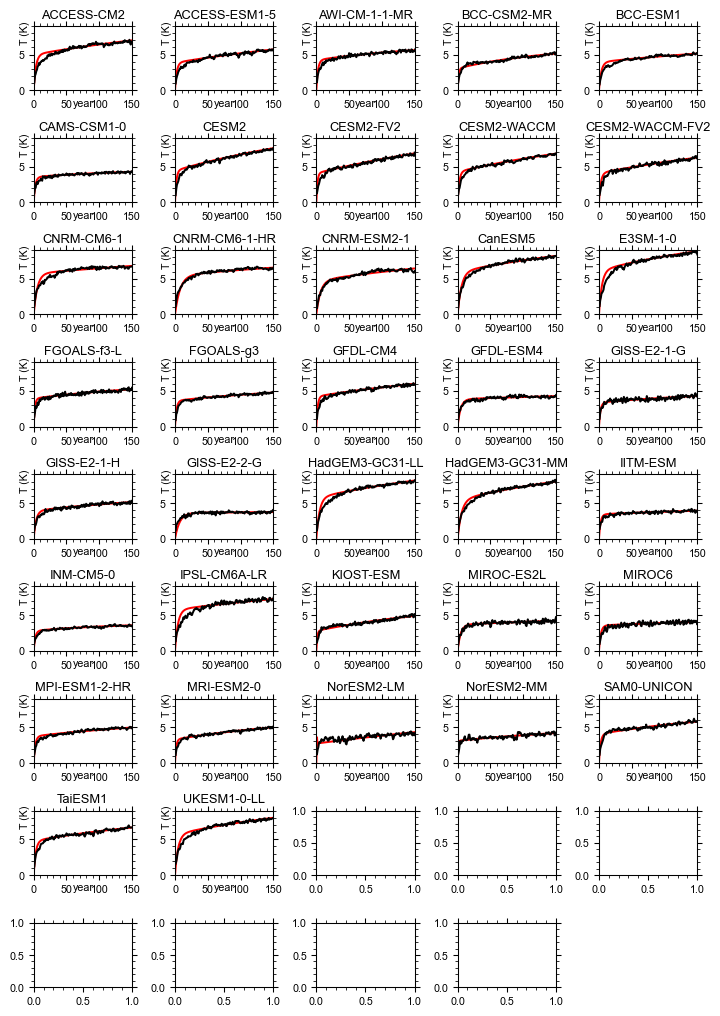

In [6]:
fig, ax = pl.subplots(9,5, figsize = (19/2.54,27/2.54))
for i, model in enumerate(sorted(accepted_models)):
    if i==44:
        labels=['Geoffroy model fit', 'CMIP6 model']
    else:
        labels=['','']
    ax[i//5,i%5].plot(np.arange(nyears[model]), tu[model], color='r', label=labels[0])
    ax[i//5,i%5].plot(np.arange(1,nyears[model]+1), T[model], color='k', label=labels[1])
    ax[i//5,i%5].set_xlabel('year')
    ax[i//5,i%5].xaxis.set_label_coords(0.5, -0.12)
    ax[i//5,i%5].set_ylabel('T (K)')
    ax[i//5,i%5].yaxis.set_label_coords(-0.035, 0.9)
    ax[i//5,i%5].set_title(model)
    ax[i//5,i%5].set_xlim(0,150)#(0,nyears[model])
    ax[i//5,i%5].set_ylim(0,9)#(0,np.max(np.concatenate((tg[model],T[model]))))
#ax[8,2].legend(loc='upper left', bbox_to_anchor=[1.15,1.1], fontsize=10);
#ax[6,2].axis('off')
ax[8,4].axis('off')
fig.tight_layout();

In [7]:
len(T4x_gregory)

37

In [8]:
len([value.magnitude for key,value in du.items()])

37

In [9]:
params = {}
params['dl'] = {}
params['dl']['name'] = 'Depth of deep ocean layer'
params['dl']['units'] = 'm'
params['dl']['model_data'] = {key:value.magnitude for key,value in dl.items()}
params['dl']['mean'] = np.array([value.magnitude for key,value in dl.items()]).mean()

params['du'] = {}
params['du']['name'] = 'Depth of upper ocean layer'
params['du']['units'] = 'm'
params['du']['model_data'] = {key:value.magnitude for key,value in du.items()}
params['du']['mean'] = np.array([value.magnitude for key,value in du.items()]).mean()

params['eta'] = {}
params['eta']['name'] = 'Heat transfer coefficient'
params['eta']['units'] = 'W m**-2 K**-1'
params['eta']['model_data'] = gamma
params['eta']['mean'] = np.mean(list(gamma.values()))

params['efficacy'] = {}
params['efficacy']['name'] = 'Efficacy of deep ocean uptake'
params['efficacy']['units'] = 'dimensionless'
params['efficacy']['model_data'] = eff
params['efficacy']['mean'] = np.mean(list(eff.values()))

params['lambda0'] = {}
params['lambda0']['name'] = 'Global climate feedback parameter'
params['lambda0']['units'] = 'W m**-2 K**-1'
params['lambda0']['model_data'] = {key:-value for key,value in lambda0.items()}
params['lambda0']['mean'] = np.array([-value for key,value in lambda0.items()]).mean()

params['F4xCO2'] = {}
params['F4xCO2']['name'] = 'Effective Radiative Forcing [Gregory] for 4xCO2'
params['F4xCO2']['units'] = 'W m**-2'
params['F4xCO2']['model_data'] = F4x_gregory
params['F4xCO2']['mean'] = np.mean(list(F4x_gregory.values()))

params['T4xCO2'] = {}
params['T4xCO2']['name'] = 'Equilibrium temperature [Gregory] for 4xCO2'
params['T4xCO2']['units'] = 'K'
params['T4xCO2']['model_data'] = T4x_gregory
params['T4xCO2']['mean'] = np.mean(list(T4x_gregory.values()))

with open("../data_input/tunings/cmip6_twolayer_tuning_params.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

In [10]:
print(lambda0[model])
print(F4x_gregory[model])
print(T4x_gregory[model])
print(du[model])
print(dl[model])
print(gamma[model])
print(model)

-0.6656268541866093
7.502375175186447
11.271142574850414
51.511874916205166 meter
577.9752504394911 meter
0.5319031564040243
UKESM1-0-LL
